In [1]:
import os

from PIL import Image
from transformers import AutoProcessor
from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL
import torch
from PIL import Image

from utils import draw_pose
from t2p.model import T2PTransformer

/Users/clement/text-to-pose/.venv/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("mps")

t2p_transformer = T2PTransformer.from_pretrained("clement-bonnet/t2p-transformer-v0")
t2p_transformer.to(device).eval()
print(
    "Number of parameters: {:,}".format(
        sum(p.numel() for p in t2p_transformer.parameters() if p.requires_grad)
    )
)

Number of parameters: 10,767,124


Number of parameters: 10,767,124


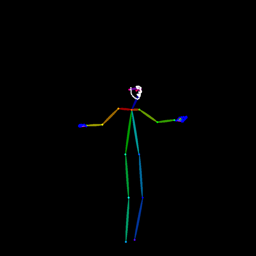

In [2]:
prompt = "a lady dancing on a stage"
num_poses = 1
temperature = 0.1
image_ratio = 1.0

clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
with torch.no_grad():
    input_ids = clip_processor(
        text=prompt, return_tensors="pt", padding="max_length", truncation=True
    )["input_ids"]
    text_embeddings = (
        t2p_transformer.clip_text_model.to(device)(input_ids.to(device), output_hidden_states=True)
        .hidden_states[-2]
        .squeeze()
    )

poses = t2p_transformer.cpu().generate(
    text_embeddings=text_embeddings,
    num_poses=num_poses,
    bbox_dist_temperature=temperature,
    pose_dist_temperature=temperature,
    image_ratio=image_ratio,
)
dw_pose = t2p_transformer.convert_to_dwpose(poses)
pose_image = Image.fromarray(draw_pose(dw_pose, 1024, int(1024 * image_ratio)))
pose_image.resize((256, 256))

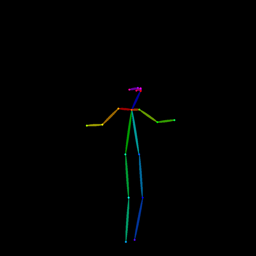

In [3]:
pose_image_only_body = Image.fromarray(draw_pose(dw_pose, 1024, int(1024 * image_ratio), only_body=True))
pose_image_only_body.resize((256, 256))

In [3]:
# load euler_a scheduler
model_id = 'stabilityai/stable-diffusion-xl-base-1.0'
euler_a = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

In [4]:
# load tencent adapter
adapter_tencent = T2IAdapter.from_pretrained(
  "TencentARC/t2i-adapter-openpose-sdxl-1.0", torch_dtype=torch.float16
).to(device)

pipe_tencent = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapter_tencent, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16", 
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
import io
import requests

import datasets
from utils import draw_pose

/Users/clement/text-to-pose/.venv/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [ ]:
dataset = datasets.load_dataset("clement-bonnet/coco_val2017_100_text_image_pose", split="test")
dataset

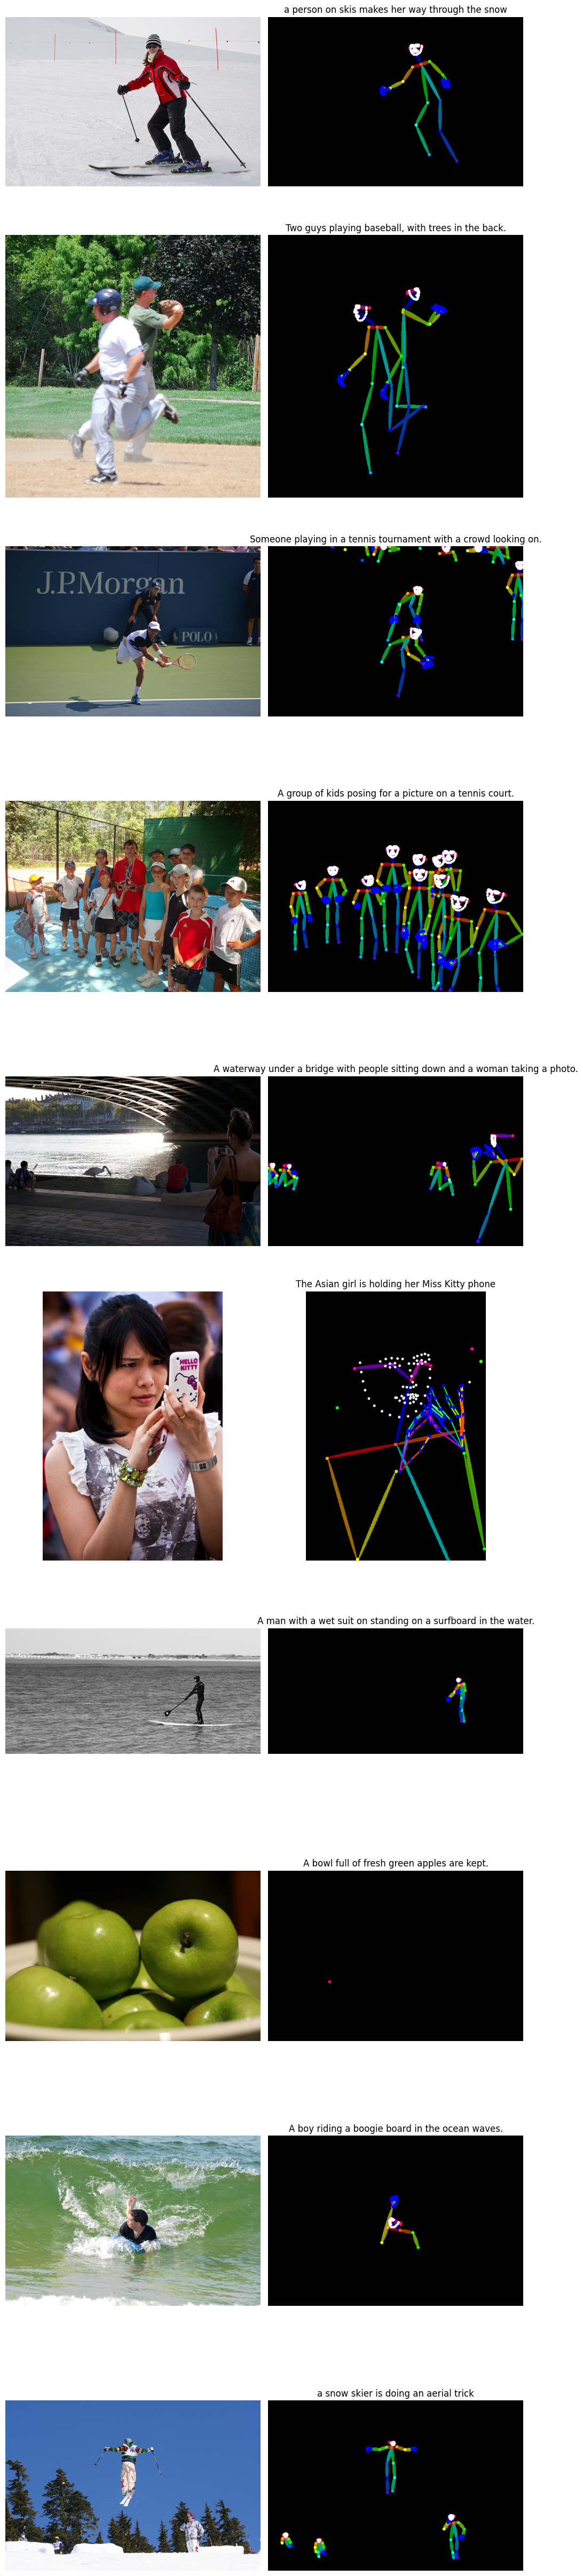

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

num_elements = 10
_, axarr = plt.subplots(num_elements, 2, figsize=(10, 5*num_elements))

for i in range(num_elements):
    file_name = dataset[i]["file_name"]
    caption = dataset[i]["caption"]
    response = requests.get(dataset[i]["coco_url"])
    image = Image.open(io.BytesIO(response.content))

    pose_image = Image.fromarray(draw_pose(dataset[i]["pose"], height=image.height, width=image.width))

    axarr[i, 0].imshow(image)
    axarr[i, 0].axis("off")
    axarr[i, 1].imshow(pose_image)
    axarr[i, 1].axis("off")
    axarr[i, 1].set_title(caption)

plt.tight_layout();

  0%|          | 0/30 [00:00<?, ?it/s]

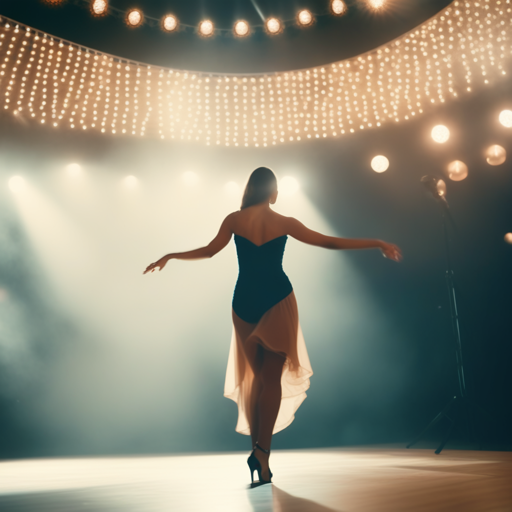

In [6]:
prompt = "a beautiful lady dancing on a stage"
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"

gen_images_tencent = pipe_tencent(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=pose_image_only_body,
  num_inference_steps=30,
  adapter_conditioning_scale=1,
  guidance_scale=7.5,
  generator=torch.Generator().manual_seed(42),
).images[0]
gen_images_tencent.resize((512, 512))

In [24]:
# load clem adapter
adapter_clem = T2IAdapter.from_pretrained(
  "clement-bonnet/t2i-adapter-sdxl-dwpose", torch_dtype=torch.float16
).to(device)

pipe_clem = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapter_clem, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16", 
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

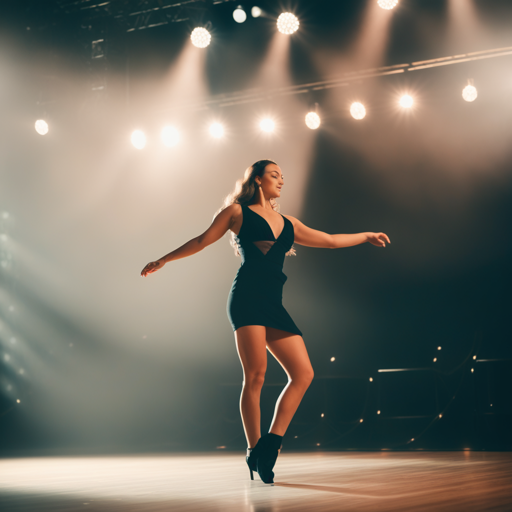

In [8]:
prompt = "a beautiful lady dancing on a stage"
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"

gen_images_clem = pipe_clem(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=pose_image,
  num_inference_steps=30,
  adapter_conditioning_scale=1,
  guidance_scale=7.5,
  generator=torch.Generator().manual_seed(42),
).images[0]
gen_images_clem.resize((512, 512))

---

In [22]:
prompt = "a grandma playing chess with her grandson"
num_poses = 1
temperature = 0.1
image_ratio = 1.0

clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
with torch.no_grad():
    input_ids = clip_processor(
        text=prompt, return_tensors="pt", padding="max_length", truncation=True
    )["input_ids"]
    text_embeddings = (
        t2p_transformer.clip_text_model.to(device)(input_ids.to(device), output_hidden_states=True)
        .hidden_states[-2]
        .squeeze()
    )

poses = t2p_transformer.cpu().generate(
    text_embeddings=text_embeddings,
    num_poses=num_poses,
    bbox_dist_temperature=temperature,
    pose_dist_temperature=temperature,
    image_ratio=image_ratio,
)
dw_pose = t2p_transformer.convert_to_dwpose(poses)
pose_image2 = Image.fromarray(draw_pose(dw_pose, 1024, int(1024 * image_ratio)))
pose_image2.resize((256, 256))

In [23]:
pose_image_only_body2 = Image.fromarray(draw_pose(dw_pose, 1024, int(1024 * image_ratio), only_body=True))
pose_image_only_body2.resize((256, 256))

  0%|          | 0/30 [00:00<?, ?it/s]

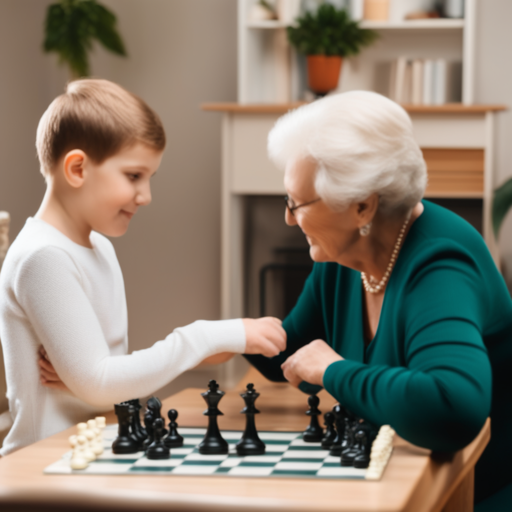

In [24]:
prompt = "a grandma playing chess with her grandson"
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"

gen_images_tencent2 = pipe_tencent(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=pose_image_only_body2,
  num_inference_steps=30,
  adapter_conditioning_scale=1,
  guidance_scale=7.5,
  generator=torch.Generator().manual_seed(42),
).images[0]
gen_images_tencent2.resize((512, 512))

  0%|          | 0/30 [00:00<?, ?it/s]

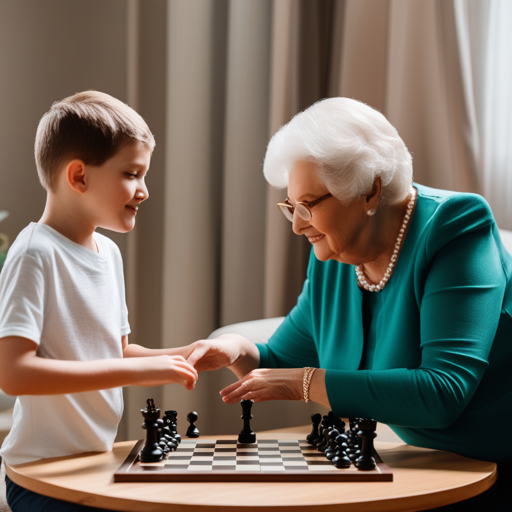

In [25]:
prompt = "a grandma playing chess with her grandson"
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"

gen_images_clem2 = pipe_clem(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=pose_image2,
  num_inference_steps=30,
  adapter_conditioning_scale=1,
  guidance_scale=7.5,
  generator=torch.Generator().manual_seed(42),
).images[0]
gen_images_clem2.resize((512, 512))

---

# Adapter Aesthetics on COCO

In [7]:
import io
import requests

import datasets
from tqdm.auto import trange

from utils import draw_pose_pil_center_crop

dataset = datasets.load_dataset("clement-bonnet/coco_val2017_100_text_image_pose", split="test")

In [ ]:
from diffusers import StableDiffusionXLImg2ImgPipeline

del pipe_tencent, pipe_clem
pipe_refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", vae=vae, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to(device)


In [ ]:
for i in trange(100):
    caption = dataset[i]["caption"]
    # response = requests.get(dataset[i]["coco_url"])
    # image = Image.open(io.BytesIO(response.content))
    # pose_image = draw_pose_pil_center_crop(dataset[i]["pose"], pose_hw_ratio=image.height / image.width)
    # pose_image.save(f"adapter_generations/pose_{i}.png")
    image = pipe_clem(
        prompt=caption,
        image=pose_image,
        num_inference_steps=30,
        adapter_conditioning_scale=0,
        adapter_conditioning_factor=0,
        guidance_scale=7.5,
        generator=torch.Generator().manual_seed(0),
    ).images[0]
    image.save(f"adapter_generations/{i}_sdxl.png")
    pipe_refiner(
        prompt=caption,
        image=image,
        strength=0.3,
        generator=torch.Generator().manual_seed(1),
    ).images[0].save(f"adapter_generations/{i}_sdxl_refiner_03.png")
    # pipe_clem(
    #     prompt=caption,
    #     image=pose_image,
    #     num_inference_steps=30,
    #     adapter_conditioning_scale=1,
    #     adapter_conditioning_factor=0.7,
    #     guidance_scale=7.5,
    #     generator=torch.Generator().manual_seed(0),
    # ).images[0].save(f"adapter_generations/clem_{i}_scale_1_factor_0.7.png")
    # pipe_clem(
    #     prompt=caption,
    #     image=pose_image,
    #     num_inference_steps=30,
    #     adapter_conditioning_scale=0.7,
    #     adapter_conditioning_factor=1,
    #     guidance_scale=7.5,
    #     generator=torch.Generator().manual_seed(0),
    # ).images[0].save(f"adapter_generations/clem_{i}_scale_0.7_factor_1.png")
    # pose_image_only_bodies = draw_pose_pil_center_crop(dataset[i]["pose"], pose_hw_ratio=image.height / image.width, only_body=True)
    # pose_image_only_bodies.save(f"adapter_generations/pose_only_body_{i}.png")
    # pipe_tencent(
    #     prompt=caption,
    #     image=pose_image_only_bodies,
    #     num_inference_steps=30,
    #     adapter_conditioning_scale=1,
    #     adapter_conditioning_factor=1,
    #     guidance_scale=7.5,
    #     generator=torch.Generator().manual_seed(0),
    # ).images[0].save(f"adapter_generations/tencent_{i}_scale_1_factor_1.png")
    # pipe_refiner(
    #     prompt=caption,
    #     image=Image.open(f"adapter_generations/tencent_{i}_scale_1_factor_1.png").convert("RGB"),
    #     strength=0.3,
    #     generator=torch.Generator().manual_seed(1),
    # ).images[0].save(f"adapter_generations/tencent_{i}_scale_1_factor_1_refiner_03.png")
    # pipe_tencent(
    #     prompt=caption,
    #     image=pose_image_only_bodies,
    #     num_inference_steps=30,
    #     adapter_conditioning_scale=1,
    #     adapter_conditioning_factor=0.7,
    #     guidance_scale=7.5,
    #     generator=torch.Generator().manual_seed(0),
    # ).images[0].save(f"adapter_generations/tencent_{i}_scale_1_factor_0.7.png")
    # pipe_tencent(
    #     prompt=caption,
    #     image=pose_image_only_bodies,
    #     num_inference_steps=30,
    #     adapter_conditioning_scale=0.7,
    #     adapter_conditioning_factor=1,
    #     guidance_scale=7.5,
    #     generator=torch.Generator().manual_seed(0),
    # ).images[0].save(f"adapter_generations/tencent_{i}_scale_0.7_factor_1.png")

In [9]:
import numpy as np

from aesthetics import get_aesthetic_classifier

aesthetic_classifier = get_aesthetic_classifier()

In [26]:
sdxl_scores = np.zeros(100)
sdxl_refiner_scores = np.zeros(100)
clem_scores_1_1 = np.zeros(100)
clem_scores_1_1_refiner = np.zeros(100)
clem_scores_07_1 = np.zeros(100)
clem_scores_1_07 = np.zeros(100)
tencent_scores_1_1 = np.zeros(100)
tencent_scores_1_1_refiner = np.zeros(100)
tencent_scores_07_1 = np.zeros(100)
tencent_scores_1_07 = np.zeros(100)
coco_scores = np.zeros(100)
for i in trange(100):
    sdxl_image = Image.open(f"adapter_generations/{i}_sdxl.png")
    sdxl_scores[i] = aesthetic_classifier.score(sdxl_image)
    sdxl_image = Image.open(f"adapter_generations/{i}_sdxl_refiner_03.png")
    sdxl_refiner_scores[i] = aesthetic_classifier.score(sdxl_image)
    clem_image = Image.open(f"adapter_generations/clem_{i}_scale_1_factor_1.png")
    clem_scores_1_1[i] = aesthetic_classifier.score(clem_image)
    clem_image = Image.open(f"adapter_generations/clem_{i}_scale_1_factor_1_refiner_03.png")
    clem_scores_1_1_refiner[i] = aesthetic_classifier.score(clem_image)
    clem_image = Image.open(f"adapter_generations/clem_{i}_scale_1_factor_0.7.png")
    clem_scores_1_07[i] = aesthetic_classifier.score(clem_image)
    clem_image = Image.open(f"adapter_generations/clem_{i}_scale_0.7_factor_1.png")
    clem_scores_07_1[i] = aesthetic_classifier.score(clem_image)
    tencent_image = Image.open(f"adapter_generations/tencent_{i}_scale_1_factor_1.png")
    tencent_scores_1_1[i] = aesthetic_classifier.score(tencent_image)
    tencent_image = Image.open(f"adapter_generations/tencent_{i}_scale_1_factor_1_refiner_03.png")
    tencent_scores_1_1_refiner[i] = aesthetic_classifier.score(tencent_image)
    tencent_image = Image.open(f"adapter_generations/tencent_{i}_scale_1_factor_0.7.png")
    tencent_scores_1_07[i] = aesthetic_classifier.score(tencent_image)
    tencent_image = Image.open(f"adapter_generations/tencent_{i}_scale_0.7_factor_1.png")
    tencent_scores_07_1[i] = aesthetic_classifier.score(tencent_image)
    response = requests.get(dataset[i]["coco_url"])
    image = Image.open(io.BytesIO(response.content))
    coco_scores[i] = aesthetic_classifier.score(image)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
sdxl_tencent_loss_1_1 = np.mean((sdxl_scores - tencent_scores_1_1)**2)
sdxl_tencent_loss_1_1_refiner = np.mean((sdxl_refiner_scores - tencent_scores_1_1_refiner)**2)
sdxl_clem_loss_1_1 = np.mean((sdxl_scores - clem_scores_1_1)**2)
sdxl_clem_loss_1_1_refiner = np.mean((sdxl_refiner_scores - clem_scores_1_1_refiner)**2)

print(f"SDXL score: {sdxl_scores.mean():.3f} ± {sdxl_scores.std():.3f}")
print(f"SDXL refiner score: {sdxl_refiner_scores.mean():.3f} ± {sdxl_refiner_scores.std():.3f}")
print(f"Clem score 1 1: {clem_scores_1_1.mean():.3f} ± {clem_scores_1_1.std():.3f}")
print(f"Clem score 1 1 refiner: {clem_scores_1_1_refiner.mean():.3f} ± {clem_scores_1_1_refiner.std():.3f}")
print(f"Clem score 0.7 1: {clem_scores_07_1.mean():.3f} ± {clem_scores_07_1.std():.3f}")
print(f"Clem score 1 0.7: {clem_scores_1_07.mean():.3f} ± {clem_scores_1_07.std():.3f}")
print(f"Tencent score 1 1: {tencent_scores_1_1.mean():.3f} ± {tencent_scores_1_1.std():.3f}")
print(f"Tencent score 1 1 refiner: {tencent_scores_1_1_refiner.mean():.3f} ± {tencent_scores_1_1_refiner.std():.3f}")
print(f"Tencent score 0.7 1: {tencent_scores_07_1.mean():.3f} ± {tencent_scores_07_1.std():.3f}")
print(f"Tencent score 1 0.7: {tencent_scores_1_07.mean():.3f} ± {tencent_scores_1_07.std():.3f}")
print(f"COCO score: {coco_scores.mean():.3f} ± {coco_scores.std():.3f}")
print(f"Clem Tencent Win-ratio 1 1: {np.mean(clem_scores_1_1 > tencent_scores_1_1)}")
print(f"Clem Tencent Win-ratio 1 1 refiner: {np.mean(clem_scores_1_1_refiner > tencent_scores_1_1_refiner)}")
print(f"Clem Tencent Win-ratio 0.7 1: {np.mean(clem_scores_07_1 > tencent_scores_07_1)}")
print(f"Clem Tencent Win-ratio 1 0.7: {np.mean(clem_scores_1_07 > tencent_scores_1_07)}")
print(f"Clem SDXL Win-ratio: {np.mean(clem_scores_1_1 > sdxl_scores)}")
print(f"Clem SDXL Win-ratio refiner: {np.mean(clem_scores_1_1_refiner > sdxl_refiner_scores)}")
print(f"Tencent SDXL Win-ratio: {np.mean(tencent_scores_1_1 > sdxl_scores)}")
print(f"Tencent SDXL Win-ratio refiner: {np.mean(tencent_scores_1_1_refiner > sdxl_refiner_scores)}")
print(f"SDXL vs Tencent Loss 1 1: {sdxl_tencent_loss_1_1:.3f}")
print(f"SDXL vs Tencent Loss 1 1 refiner: {sdxl_tencent_loss_1_1_refiner:.3f}")
print(f"SDXL vs Clem Loss 1 1: {sdxl_clem_loss_1_1:.3f}")
print(f"SDXL vs Clem Loss 1 1 refiner: {sdxl_clem_loss_1_1_refiner:.3f}")

SDXL score: 5.713 ± 0.303
SDXL refiner score: 5.858 ± 0.331
Clem score 1 1: 5.484 ± 0.312
Clem score 1 1 refiner: 5.745 ± 0.303
Clem score 0.7 1: 5.581 ± 0.354
Clem score 1 0.7: 5.492 ± 0.316
Tencent score 1 1: 5.346 ± 0.400
Tencent score 1 1 refiner: 5.654 ± 0.321
Tencent score 0.7 1: 5.520 ± 0.360
Tencent score 1 0.7: 5.365 ± 0.402
COCO score: 5.095 ± 0.449
Clem Tencent Win-ratio 1 1: 0.67
Clem Tencent Win-ratio 1 1 refiner: 0.7
Clem Tencent Win-ratio 0.7 1: 0.52
Clem Tencent Win-ratio 1 0.7: 0.66
Clem SDXL Win-ratio: 0.19
Clem SDXL Win-ratio refiner: 0.36
Tencent SDXL Win-ratio: 0.17
Tencent SDXL Win-ratio refiner: 0.26
SDXL vs Tencent Loss 1 1: 0.279
SDXL vs Tencent Loss 1 1 refiner: 0.155
SDXL vs Clem Loss 1 1: 0.151
SDXL vs Clem Loss 1 1 refiner: 0.136
